Modules:

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

To align with the methodology of Prescott and Mehra (1985), The monthly return of the S&P 500 index is annualized and used as the market return. The annual average return of the 3-month Treasury bond yield is used as the risk-free rate. The monthly Personal Consumption Expenditures (PCE) is annualized and used as the annual growth rate of consumption, while the monthly Consumer Price Index (CPI) is annualized and used as the annual inflation rate. The data is obtained from the Federal Reserve Bank of St. Louis (FRED) database and Market Insights.
<br>
<br>
The data cleaned and prepared for the analysis as follows: 


In [20]:
# Read df
df = pd.read_excel("data.xlsx")

### SP500 ###
# Select date and yield from SP500
col_sel_sp500 = ["date_sp500", "sp500"]

# Create df for SP500
df_sp500 = df[col_sel_sp500].copy()

# Convert date column in df_sp500 to datetime
df_sp500["date_sp500"] = pd.to_datetime(df_sp500["date_sp500"])

# Remove missing values
df_sp500 = df_sp500.iloc[:660,:].copy()

# Set index
df_sp500 = df_sp500.set_index("date_sp500")



### Yield ###
# Select date and yield from df
col_sel_d_yield = ["date_yield", "yield"]

# Create df for yield
df_d_yield = df[col_sel_d_yield].copy()

# Convert date column in df_yield to datetime
df_d_yield["date_yield"] = pd.to_datetime(df_d_yield["date_yield"])

# Set date as index
df_d_yield.set_index("date_yield", inplace=True)

# Monthly yield in pct.
df_m_yield =df_d_yield["yield"].resample("1YS").mean()/100

# Reset index to create df 
df_m_yield = df_m_yield.reset_index()

# Set index
df_m_yield = df_m_yield.set_index("date_yield")



### PCE ### 
# Select date and yield from PCE
col_sel_pce = ["date_pce", "pce"]

# Create df for PCE
df_pce = df[col_sel_pce].copy()

# Convert date column in df_pce to datetime
df_pce["date_pce"] = pd.to_datetime(df_pce["date_pce"])

# Remove missing values
df_pce = df_pce.iloc[:793,:].copy()

# Set index
df_pce = df_pce.set_index("date_pce")



### CPI ###
# Select date and yield from CPI
col_sel_cpi = ["date_cpi", "cpi"]

# Create df for CPI
df_cpi = df[col_sel_cpi].copy()

# Convert date column in df_pce to datetime
df_cpi["date_cpi"] = pd.to_datetime(df_cpi["date_cpi"])

# Remove missing values
df_cpi = df_cpi.iloc[:937,:].copy()

# Set index
df_cpi = df_cpi.set_index("date_cpi")



### Final DataFrame ###
# Merge dfs
df_final = df_m_yield.join([df_sp500, df_pce, df_cpi], how="left")

# Change index name
df_final.index.name = 'date'

# Define your start and end dates
start_date = '1985-01-01'
end_date = '2025-01-01'

# Slice the DataFrame between the two dates
df_final = df_final.loc[start_date:end_date]



### Final DataFrame ###
# Filter for January
df_final = df_final[df_final.index.month.isin([1])].copy()

# Ln returns nominal yield
df_final["yield_nom_ret"] = np.log(1+df_final["yield"])

# Ln returns all else
df_final[["sp500_nom_ret", "pce_nom_ret", "cpi_chg"]] = np.log(df_final.iloc[:, 1:4] / df_final.iloc[:, 1:4].shift(1))

# Real returns
df_final[["yield_real_ret", "sp500_real_ret", "pce_real_ret"]] = (
df_final[["yield_nom_ret", "sp500_nom_ret", "pce_nom_ret"]]
    .subtract(df_final["cpi_chg"], axis=0))

# Risk premium
df_final["equity_prem"] = (df_final["sp500_real_ret"].subtract(df_final["yield_real_ret"], axis=0))

Descriptive statistics:

In [21]:
# Descriptive statistics for real returns 
df_final.iloc[:,7:].describe()

,cpi_chg,yield_real_ret,sp500_real_ret,pce_real_ret,equity_prem
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.027621,0.003597,0.060266,0.023677,0.056670
std,0.015270,0.021369,0.161482,0.016307,0.159498
min,-0.002302,-0.052407,-0.511141,-0.025797,-0.513786
25%,0.016658,-0.013543,-0.018240,0.015810,-0.015199
50%,0.026788,0.003215,0.108483,0.026233,0.088941
75%,0.033149,0.021246,0.159677,0.032583,0.172945
max,0.073047,0.044381,0.274090,0.050082,0.265136


Plots for data exploration:

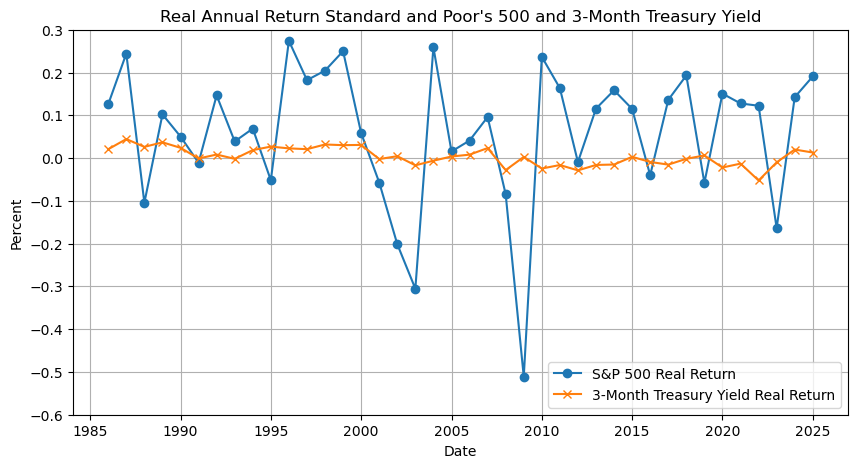

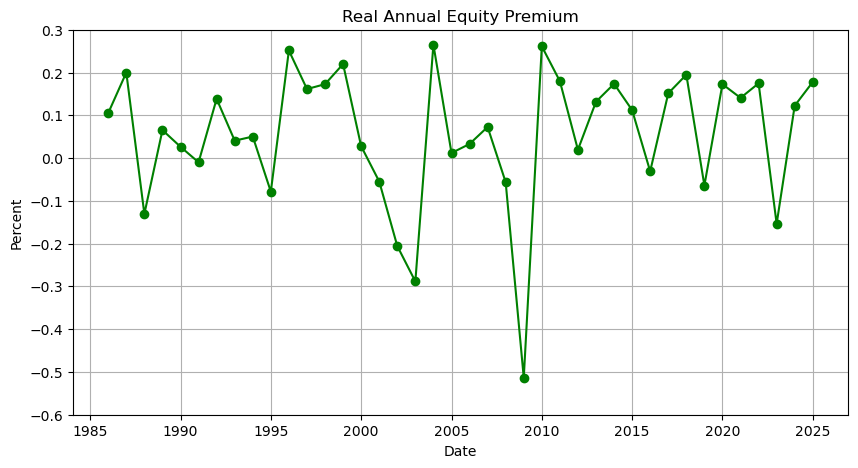

In [23]:
# Real Market Return and Yield
plt.figure(figsize=(10, 5))
plt.plot(df_final.index, df_final['sp500_real_ret'], marker='o', label="S&P 500 Real Return")
plt.plot(df_final.index, df_final['yield_real_ret'], marker='x', label="3-Month Treasury Yield Real Return")
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Return Standard and Poor\'s 500 and 3-Month Treasury Yield')
plt.legend(loc="lower right")
plt.ylim(-0.6, 0.3)
plt.grid()
plt.show()



# Real Risk Premium
plt.figure(figsize=(10, 5))
plt.plot(df_final.index, df_final['equity_prem'], marker='o', color="green")
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Equity Premium')
plt.ylim(-0.6, 0.3)
plt.grid()
plt.show()

Model